# Module 03 — Housing Price Predictions
## CSE 450 Machine Learning | Team 8

**Team Members**: Dawson, Peter, Tanner

**Objective**: Predict King County house prices using XGBoost regression

---

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print('All imports loaded successfully.')

/home/dawson/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


All imports loaded successfully.


## 2. Load Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')
mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

print(f'Training:     {df.shape[0]:,} rows x {df.shape[1]} cols')
print(f'Holdout:      {holdout.shape[0]:,} rows x {holdout.shape[1]} cols')
print(f'Mini holdout: {mini_holdout.shape[0]:,} rows x {mini_holdout.shape[1]} cols')

Training:     20,000 rows x 21 cols
Holdout:      1,613 rows x 20 cols
Mini holdout: 81 rows x 20 cols


## 3. Data Exploration

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  str    
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_living15  20

In [4]:
df.describe().round(2)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.000000e+04,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,4.580297e+09,3.37,2.12,2079.88,15015.33,1.50,0.01,0.23,3.41,7.66,1790.23,289.65,1971.10,82.73,98077.88,47.56,-122.21,1986.39,12748.96,539436.71
std,2.875295e+09,0.93,0.77,919.43,39701.35,0.54,0.09,0.77,0.65,1.18,829.59,441.54,29.37,397.87,53.44,0.14,0.14,685.21,27076.49,366433.44
min,1.000102e+06,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00,75000.00
25%,2.123049e+09,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1951.75,0.00,98033.00,47.47,-122.33,1490.00,5100.00,322000.00
50%,3.904955e+09,3.00,2.25,1910.00,7620.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7622.00,450000.00
75%,7.309825e+09,4.00,2.50,2550.00,10710.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98117.00,47.68,-122.12,2360.00,10088.25,641625.00
max,9.900000e+09,33.00,8.00,13540.00,1164794.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.32,6210.00,871200.00,7700000.00


In [5]:
# Missing values
missing = df.isnull().sum()
print('Missing values:')
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print('None found \u2014 dataset is clean.')

Missing values:
None found — dataset is clean.


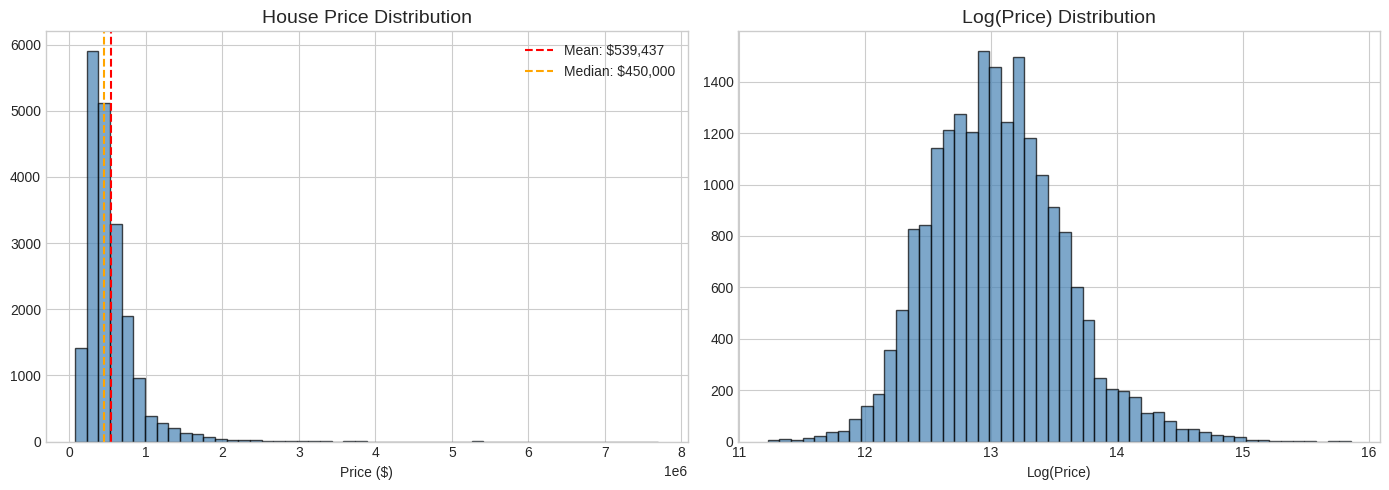

Price range: $75,000 to $7,700,000
Skewness: 4.09


In [6]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('House Price Distribution', fontsize=14)
axes[0].set_xlabel('Price ($)')
axes[0].axvline(df['price'].mean(), color='red', linestyle='--',
                label=f'Mean: ${df["price"].mean():,.0f}')
axes[0].axvline(df['price'].median(), color='orange', linestyle='--',
                label=f'Median: ${df["price"].median():,.0f}')
axes[0].legend()

axes[1].hist(np.log1p(df['price']), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title('Log(Price) Distribution', fontsize=14)
axes[1].set_xlabel('Log(Price)')

plt.tight_layout()
plt.show()
print(f'Price range: ${df["price"].min():,.0f} to ${df["price"].max():,.0f}')
print(f'Skewness: {df["price"].skew():.2f}')

In [7]:
# Correlations with price
corr = df.select_dtypes(include=[np.number]).corr()['price'].sort_values(ascending=False)
print('Correlation with price:')
print(corr.to_string())

Correlation with price:
price            1.000000
sqft_living      0.703920
grade            0.666447
sqft_above       0.607082
sqft_living15    0.585374
bathrooms        0.527989
view             0.395961
sqft_basement    0.325183
lat              0.307516
bedrooms         0.307281
waterfront       0.260133
floors           0.254428
yr_renovated     0.121534
sqft_lot         0.090317
sqft_lot15       0.082413
yr_built         0.054187
condition        0.035146
long             0.023976
id              -0.016081
zipcode         -0.055857


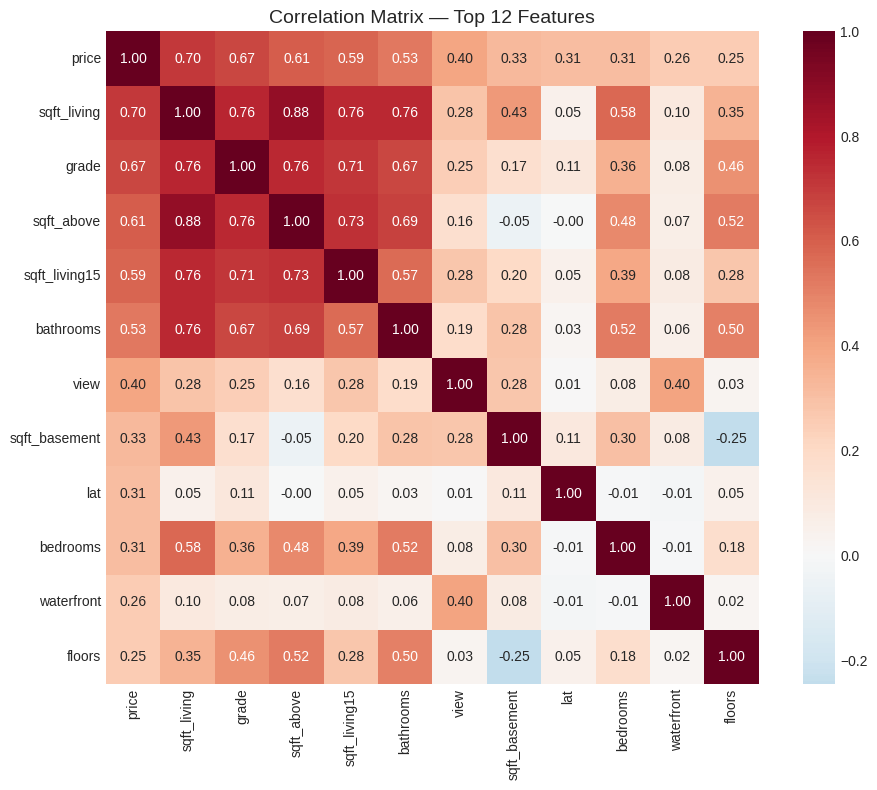

In [8]:
# Correlation heatmap \u2014 top features
top_feats = corr.abs().sort_values(ascending=False).head(12).index
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[top_feats].corr(), annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=ax, square=True)
ax.set_title('Correlation Matrix \u2014 Top 12 Features', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Preprocessing & Feature Engineering

In [9]:
def preprocess(data, is_training=True, train_columns=None):
    """
    Apply identical preprocessing to training and holdout data.
    Uses zipcode + lat + long for location (all 3 outperform subsets).
    """
    df = data.copy()

    # --- Parse date ---
    df['date'] = pd.to_datetime(df['date'])
    df['year_sold'] = df['date'].dt.year
    df['month_sold'] = df['date'].dt.month

    # --- Age features ---
    df['age'] = df['year_sold'] - df['yr_built']
    df['renovated'] = (df['yr_renovated'] > 0).astype(int)
    df['years_since_renovation'] = np.where(
        df['yr_renovated'] > 0,
        df['year_sold'] - df['yr_renovated'],
        df['age']
    )

    # --- Derived features ---
    df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot'].clip(lower=1)
    df['sqft_per_room'] = df['sqft_living'] / df['total_rooms'].clip(lower=1)
    df['above_ground_ratio'] = df['sqft_above'] / df['sqft_living'].clip(lower=1)

    # --- Drop raw columns we replaced ---
    drop_cols = ['id', 'date', 'yr_built', 'yr_renovated']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    # --- Return ---
    if is_training:
        y = df.pop('price')
        return df, y
    else:
        if 'price' in df.columns:
            df = df.drop(columns=['price'])
        if train_columns is not None:
            for col in train_columns:
                if col not in df.columns:
                    df[col] = 0
            df = df[train_columns]
        return df

print('Preprocessing function defined.')

Preprocessing function defined.


In [10]:
# Apply to training data
X, y = preprocess(df, is_training=True)

print(f'Features: {X.shape[1]} columns')
print(f'Target: {len(y):,} values')
print(f'\nFeature list:\n{list(X.columns)}')

Features: 26 columns
Target: 20,000 values

Feature list:
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'age', 'renovated', 'years_since_renovation', 'has_basement', 'total_rooms', 'living_lot_ratio', 'sqft_per_room', 'above_ground_ratio']


In [11]:
# Sanity checks
print('Missing values after preprocessing:')
miss = X.isnull().sum()
print(miss[miss > 0] if miss.sum() > 0 else 'None')
print(f'\nInfinite values: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}')

Missing values after preprocessing:
None

Infinite values: 0


## 5. Train/Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f'Training set: {X_train.shape[0]:,} rows')
print(f'Test set:     {X_test.shape[0]:,} rows')

Training set: 16,000 rows
Test set:     4,000 rows


In [13]:
def evaluate(model, X_test, y_test, name='Model'):
    """Evaluate a model and return metrics dict."""
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds) * 100

    print(f'{name}:')
    print(f'  RMSE:  ${rmse:,.2f}')
    print(f'  MAE:   ${mae:,.2f}')
    print(f'  R2:    {r2:.4f}')
    print(f'  MAPE:  {mape:.2f}%')
    print()
    return {
        'model': name, 'rmse': rmse, 'mae': mae,
        'r2': r2, 'mape': mape, 'preds': preds
    }

results = {}
print('Evaluation function defined.')

Evaluation function defined.


## 6. Model Training

In [14]:
# Baseline: predict mean price
class MeanBaseline:
    def fit(self, X, y):
        self.mean_ = y.mean()
        return self
    def predict(self, X):
        return np.full(len(X), self.mean_)

baseline = MeanBaseline().fit(X_train, y_train)
results['Baseline'] = evaluate(baseline, X_test, y_test, 'Baseline (Mean)')

Baseline (Mean):
  RMSE:  $388,475.67
  MAE:   $238,572.79
  R2:    -0.0006
  MAPE:  53.40%



In [15]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
results['Linear'] = evaluate(lr, X_test, y_test, 'Linear Regression')

Linear Regression:
  RMSE:  $207,086.76
  MAE:   $124,821.47
  R2:    0.7157
  MAPE:  24.56%



In [16]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
results['RF'] = evaluate(rf, X_test, y_test, 'Random Forest')

Random Forest:
  RMSE:  $137,134.21
  MAE:   $71,369.85
  R2:    0.8753
  MAPE:  13.21%



In [17]:
# Gradient Boosting (sklearn)
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
results['GB'] = evaluate(gb, X_test, y_test, 'Gradient Boosting')

Gradient Boosting:
  RMSE:  $127,338.53
  MAE:   $68,248.43
  R2:    0.8925
  MAPE:  12.70%



In [18]:
# XGBoost (default hyperparameters)
xgb_default = XGBRegressor(
    n_estimators=500, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1
)
xgb_default.fit(X_train, y_train)
results['XGB_default'] = evaluate(xgb_default, X_test, y_test, 'XGBoost (default)')

XGBoost (default):
  RMSE:  $131,583.97
  MAE:   $64,889.74
  R2:    0.8852
  MAPE:  12.12%



## 7. Hyperparameter Tuning (XGBoost)

GridSearchCV to find the best XGBoost parameters. This may take a few minutes.

In [19]:
param_grid = {
    'n_estimators': [300, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [3, 5],
}

print(f'Grid search: {np.prod([len(v) for v in param_grid.values()])} combinations x 3 folds')
print('Training...')

xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

print(f'\nBest parameters: {xgb_grid.best_params_}')
print(f'Best CV RMSE: ${np.sqrt(-xgb_grid.best_score_):,.2f}')

Grid search: 36 combinations x 3 folds
Training...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 800, 'subsample': 0.8}
Best CV RMSE: $116,244.72


In [20]:
# Evaluate the tuned XGBoost
best_xgb = xgb_grid.best_estimator_
results['XGB_tuned'] = evaluate(best_xgb, X_test, y_test, 'XGBoost (tuned)')

XGBoost (tuned):
  RMSE:  $128,590.94
  MAE:   $66,607.58
  R2:    0.8904
  MAPE:  12.50%



## 8. Cross-Validation

In [21]:
# 5-Fold Cross-Validation on the best model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_xgb, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print('5-Fold Cross-Validation Results:')
print(f'  RMSE scores: {[f"${x:,.0f}" for x in cv_rmse]}')
print(f'  Mean RMSE:   ${cv_rmse.mean():,.2f}')
print(f'  Std RMSE:    ${cv_rmse.std():,.2f}')
print(f'  CV:          {cv_rmse.std()/cv_rmse.mean()*100:.1f}%')

5-Fold Cross-Validation Results:
  RMSE scores: ['$126,301', '$120,721', '$108,881', '$108,081', '$116,094']
  Mean RMSE:   $116,015.70
  Std RMSE:    $6,953.84
  CV:          6.0%


## 9. Feature Importance

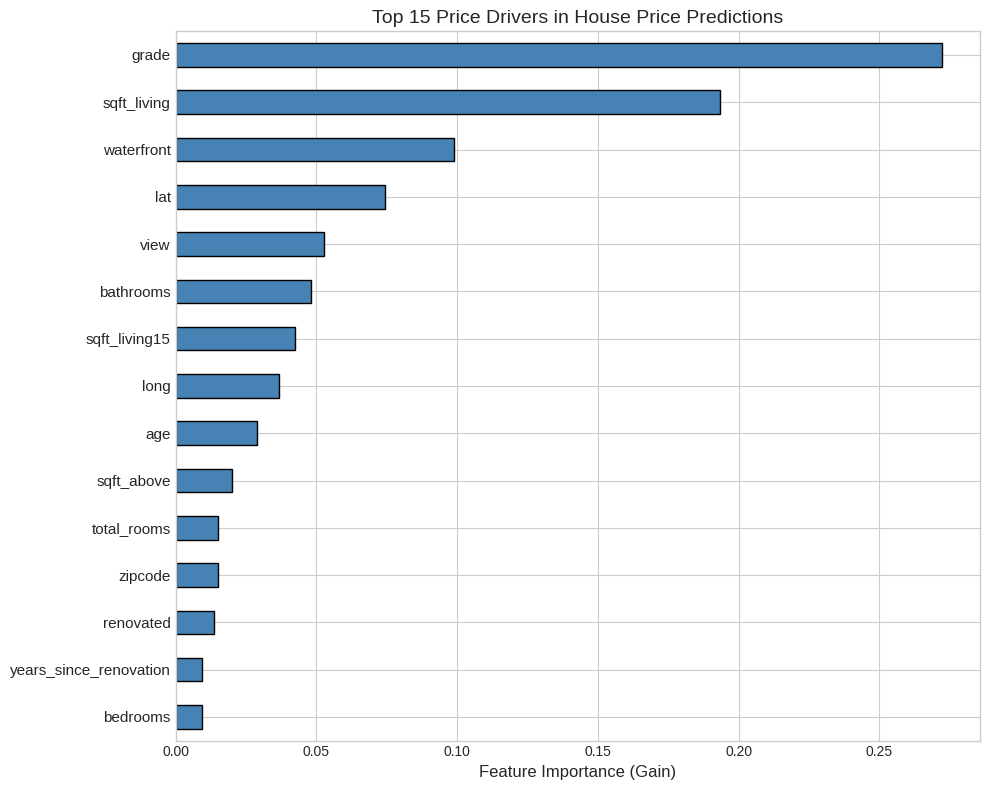


Top 7 Price Drivers:
  1. grade: importance = 0.2721
  2. sqft_living: importance = 0.1932
  3. waterfront: importance = 0.0989
  4. lat: importance = 0.0745
  5. view: importance = 0.0526
  6. bathrooms: importance = 0.0482
  7. sqft_living15: importance = 0.0424


In [22]:
# Feature importance from tuned XGBoost
importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
top_n = 15
top_features = importances.nlargest(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
top_features.sort_values().plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Feature Importance (Gain)', fontsize=12)
ax.set_title(f'Top {top_n} Price Drivers in House Price Predictions', fontsize=14)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()

print('\nTop 7 Price Drivers:')
for i, (feat, imp) in enumerate(importances.nlargest(7).items(), 1):
    print(f'  {i}. {feat}: importance = {imp:.4f}')

## 10. Model Comparison

In [23]:
# Compare all models side by side
comparison = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'preds'}
    for r in results.values()
]).set_index('model')

print(comparison.to_string())
print()
best_model_name = comparison['rmse'].idxmin()
print(f'Best model: {best_model_name} (lowest RMSE)')

                            rmse            mae        r2       mape
model                                                               
Baseline (Mean)    388475.670597  238572.786386 -0.000630  53.397131
Linear Regression  207086.755209  124821.469698  0.715652  24.556497
Random Forest      137134.205028   71369.848118  0.875308  13.207192
Gradient Boosting  127338.525312   68248.431995  0.892486  12.695161
XGBoost (default)  131583.972157   64889.740023  0.885197  12.120562
XGBoost (tuned)    128590.942314   66607.575547  0.890361  12.497324

Best model: Gradient Boosting (lowest RMSE)


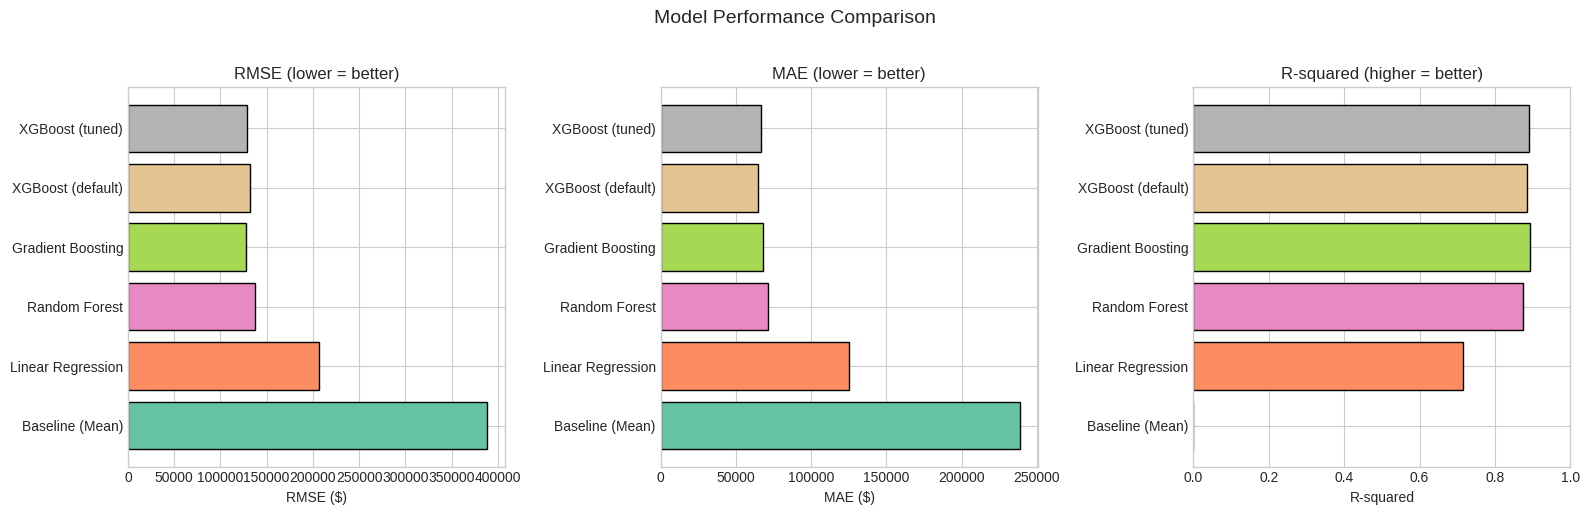

In [24]:
# Model comparison chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
models = comparison.index.tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

axes[0].barh(models, comparison['rmse'], color=colors, edgecolor='black')
axes[0].set_xlabel('RMSE ($)')
axes[0].set_title('RMSE (lower = better)')

axes[1].barh(models, comparison['mae'], color=colors, edgecolor='black')
axes[1].set_xlabel('MAE ($)')
axes[1].set_title('MAE (lower = better)')

axes[2].barh(models, comparison['r2'], color=colors, edgecolor='black')
axes[2].set_xlabel('R-squared')
axes[2].set_title('R-squared (higher = better)')
axes[2].set_xlim(0, 1)

plt.suptitle('Model Performance Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 11. Visualizations

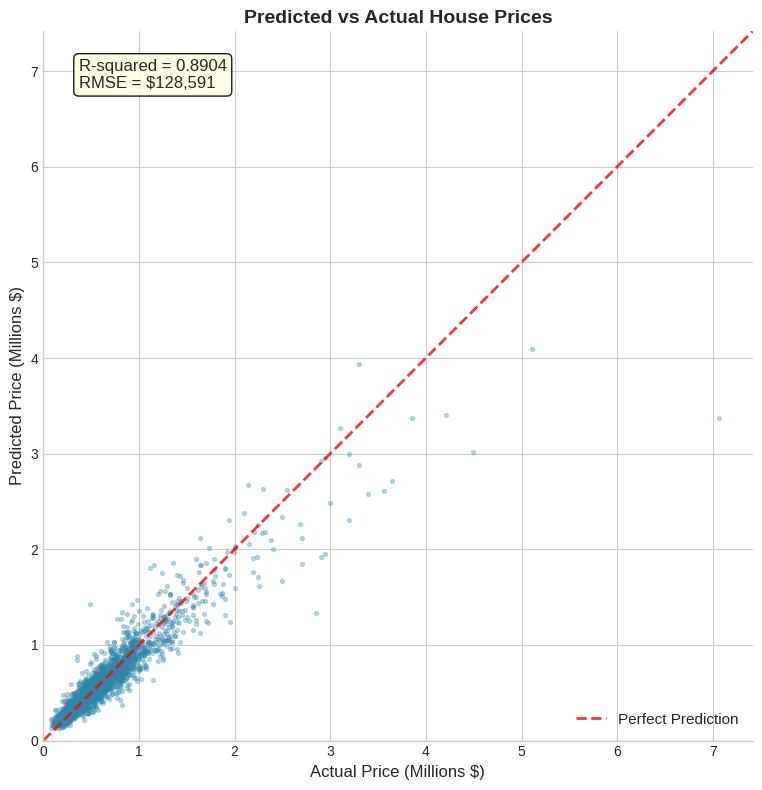

In [25]:
# Predicted vs Actual
preds_test = best_xgb.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test / 1e6, preds_test / 1e6, alpha=0.3, s=8, color='#2E86AB')
lims = [0, max(y_test.max(), preds_test.max()) / 1e6 * 1.05]
ax.plot(lims, lims, 'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
ax.set_xlabel('Actual Price (Millions $)', fontsize=12)
ax.set_ylabel('Predicted Price (Millions $)', fontsize=12)
ax.set_title('Predicted vs Actual House Prices', fontsize=14, fontweight='bold')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
ax.legend(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

r2_val = r2_score(y_test, preds_test)
rmse_val = np.sqrt(mean_squared_error(y_test, preds_test))
ax.text(0.05, 0.92, f'R-squared = {r2_val:.4f}\nRMSE = ${rmse_val:,.0f}',
        transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

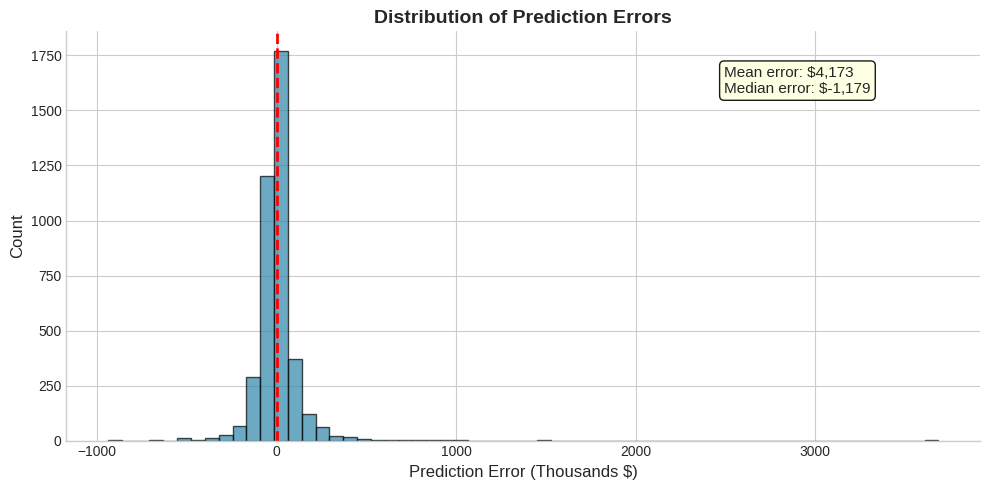

In [26]:
# Residual distribution
residuals = y_test - preds_test

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(residuals / 1000, bins=60, edgecolor='black', alpha=0.7, color='#2E86AB')
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (Thousands $)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(0.72, 0.85, f'Mean error: ${residuals.mean():,.0f}\nMedian error: ${residuals.median():,.0f}',
        transform=ax.transAxes, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

## 12. Holdout Predictions

**CRITICAL**: Filename must be `team8-module3-predictions.csv` (DASHES, not underscores!)

In [27]:
# Preprocess holdout data using same function
train_columns = X.columns.tolist()
holdout_X = preprocess(holdout, is_training=False, train_columns=train_columns)

print(f'Holdout features: {holdout_X.shape}')
print(f'Training features: {X.shape}')
print(f'Columns match: {list(holdout_X.columns) == train_columns}')

Holdout features: (1613, 26)
Training features: (20000, 26)
Columns match: True


In [28]:
# Generate predictions and save
holdout_preds = best_xgb.predict(holdout_X)

submission = pd.DataFrame({'price': holdout_preds})
submission.to_csv('team8-module3-predictions.csv', index=False)

# VERIFY
check = pd.read_csv('team8-module3-predictions.csv')
print('=== HOLDOUT VERIFICATION ===')
print(f'Filename:        team8-module3-predictions.csv')
print(f'Columns:         {list(check.columns)}')
print(f'Rows:            {len(check)}')
print(f'All same value?  {check["price"].nunique() == 1}  (should be False!)')
print(f'Min prediction:  ${check["price"].min():,.2f}')
print(f'Max prediction:  ${check["price"].max():,.2f}')
print(f'Mean prediction: ${check["price"].mean():,.2f}')
print()
print('First 10 predictions:')
print(check.head(10).to_string())

=== HOLDOUT VERIFICATION ===
Filename:        team8-module3-predictions.csv
Columns:         ['price']
Rows:            1613
All same value?  False  (should be False!)
Min prediction:  $126,512.28
Max prediction:  $4,120,510.80
Mean prediction: $544,596.04

First 10 predictions:
        price
0   388922.47
1   896725.20
2  1209949.00
3  2116252.80
4   714043.60
5   240404.66
6   766211.00
7   644228.70
8   432915.62
9   556962.44


## 13. Mini Holdout Check (PM Checkin)

In [29]:
# Preprocess mini holdout
mini_X = preprocess(mini_holdout, is_training=False, train_columns=train_columns)
print(f'Mini holdout features: {mini_X.shape}')

# Generate predictions
mini_preds = best_xgb.predict(mini_X)

# Save
mini_sub = pd.DataFrame({'price': mini_preds})
mini_sub.to_csv('team8-module3-mini-predictions.csv', index=False)

# Verify
check_mini = pd.read_csv('team8-module3-mini-predictions.csv')
print(f'Saved: team8-module3-mini-predictions.csv')
print(f'Rows: {len(check_mini)}')
print(f'Sample predictions: {check_mini["price"].head().tolist()}')

Mini holdout features: (81, 26)
Saved: team8-module3-mini-predictions.csv
Rows: 81
Sample predictions: [453709.66, 675198.3, 192363.83, 362619.22, 432915.62]
